Whole notebook has been run on Google colab pro
created by: Michał Chrzanowski

important note, if model stucks at around 25% accuracy restart whole model and calculate again

In [1]:
!lsb_release -a #Linux info
!cat /proc/cpuinfo # CPU info
!df -h #disc info
!cat /proc/meminfo #RAM info
!sudo apt install speedtest-cli #library for speedtesting
!speedtest-cli # network speed test

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.6 LTS
Release:	18.04
Codename:	bionic
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass

In [2]:
!nvidia-smi #GPU info

Mon Sep 26 13:12:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# I decided to use external plotting service Weights and biases. It provides easy live preview of model state and  allows convenient runs comparasion
!pip install wandb
!wandb login 33cccacf373072ab6a5edc82d4770dddf40d42fb
import wandb

#mount google drive
from google.colab import drive
drive.mount('/content/drive')
#copy data from Google drive to internal machine drive for faster loading
google_path = "/content/drive/MyDrive/CNN_Data"
train_path = "/content/data"
!cp -R "$google_path" $train_path

In [2]:
# Imports
import time
import torch
import torchvision  # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.transforms as transforms  # Transformations and augmentations
from torch import optim  # For optimizers
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader #Dataloader module
from torch.utils.data import Dataset # Dataset module
import torchvision.transforms as transforms
from tqdm import tqdm #nice progress bar
import panads as pd
import numpy as np

# Libraries for dataloader
from os import listdir
from os.path import isfile, join
from PIL import Image
#Checking whether GPU RAM is empty
print('allocated CUDA memory: ',torch.cuda.memory_allocated())
print('cached CUDA memory: ',torch.cuda.memory_cached())

allocated CUDA memory:  0
cached CUDA memory:  0


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:393: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [3]:
# image processing of images. In the end i decided not to use it in this model
import matplotlib.pyplot as plt
from skimage.io import imshow, imread
from skimage.color import rgb2hsv, hsv2rgb
import cv2
def color_isolate(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image_hsv = rgb2hsv(image[:,:,:3])   
    #MASK
    mask_1 = image_hsv [:,:,0] > 200/360
    mask_2 = image_hsv [:,:,0] < 280/360
    saturation_1 = image_hsv [:,:,1] > 0.35
    saturation_2 = image_hsv [:,:,1] < 0.70
    
    mask= mask_1*mask_1*saturation_1*saturation_2

    image_filtered = np.dstack((image[:,:,0]*mask,
                                image[:,:,1]*mask,
                                image[:,:,2]*mask))

    return image_filtered

In [60]:
# DATALOADERS

# Train Loader
class BloodCell_train(Dataset):
    def __init__(self, transform):
        self.labels = []
        self.dirName_1 = '/content/data/Blood_Cell_Images/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL' # path to training data with EOSINOPHILS cells
        self.dirName_2 = '/content/data/Blood_Cell_Images/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE' # path to training data with LYMPHOCYTES cells
        self.dirName_3 = '/content/data/Blood_Cell_Images/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE' # path to training data with MONOCYTES cells
        self.dirName_4 = '/content/data/Blood_Cell_Images/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL' # path to training data with NEUTROPHILS cells
        self.files_names = []
        self.transform = transform
        self.load_images()
    

    def load_images(self):

        # create list of paths to images
        files_1 = [join(self.dirName_1, f) for f in listdir(self.dirName_1) if isfile(join(self.dirName_1, f))]
        files_2 = [join(self.dirName_2, f) for f in listdir(self.dirName_2) if isfile(join(self.dirName_2, f))]
        files_3 = [join(self.dirName_3, f) for f in listdir(self.dirName_3) if isfile(join(self.dirName_3, f))]
        files_4 = [join(self.dirName_4, f) for f in listdir(self.dirName_4) if isfile(join(self.dirName_4, f))]
        

        # connect lists of different cells in one big list
        self.files_names = files_1 + files_2 + files_3 + files_4

        # creating label list
        for file_name in tqdm(files_1):
            self.labels.append(0)

        for file_name in tqdm(files_2):
            self.labels.append(1)

        for file_name in tqdm(files_3):
            self.labels.append(2)

        for file_name in tqdm(files_4):
            self.labels.append(3)

        del files_1
        del files_2
        del files_3
        del files_4

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image=cv2.imread(self.files_names[index])
        #image = color_isolate(image.astype(np.float32))
        y_label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

# Test Loader
class BloodCell_test(Dataset):
    def __init__(self, transform):
        self.labels = []
        self.dirName_1 = '/content/data/Blood_Cell_Images/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL' # path to test data with EOSINOPHILS cells
        self.dirName_2 = '/content/data/Blood_Cell_Images/dataset2-master/dataset2-master/images/TEST/LYMPHOCYTE' # path to test data with LYMPHOCYTES cells
        self.dirName_3 = '/content/data/Blood_Cell_Images/dataset2-master/dataset2-master/images/TEST/MONOCYTE' # path to test data with MONOCYTES cells
        self.dirName_4 = '/content/data/Blood_Cell_Images/dataset2-master/dataset2-master/images/TEST/NEUTROPHIL' # path to test data with NEUTROPHILS cells
        self.files_names = []
        self.transform = transform
        self.load_images()
        

    def load_images(self):

        # create list of paths to images
        files_1 = [join(self.dirName_1, f) for f in listdir(self.dirName_1) if isfile(join(self.dirName_1, f))]
        files_2 = [join(self.dirName_2, f) for f in listdir(self.dirName_2) if isfile(join(self.dirName_2, f))]
        files_3 = [join(self.dirName_3, f) for f in listdir(self.dirName_3) if isfile(join(self.dirName_3, f))]
        files_4 = [join(self.dirName_4, f) for f in listdir(self.dirName_4) if isfile(join(self.dirName_4, f))]
        
        # connect lists of different cells in one big list
        self.files_names = files_1 + files_2 + files_3 + files_4

        # creating label list
        for file_name in tqdm(files_1):
            self.labels.append(0)

        for file_name in tqdm(files_2):
            self.labels.append(1)

        for file_name in tqdm(files_3):
            self.labels.append(2)

        for file_name in tqdm(files_4):
            self.labels.append(3)

        del files_1
        del files_2
        del files_3
        del files_4
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image=cv2.imread(self.files_names[index])
        #image = color_isolate(image.astype(np.float32))
        y_label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return (image, y_label)


In [61]:
# model creation
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=9,
            kernel_size=(11, 11),
            stride=(1, 1),
            padding=(1,1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=9,
            out_channels=27,
            kernel_size=(7, 7),
            stride=(1, 1),
            padding=(0,0),
        )
        self.conv3 = nn.Conv2d(
            in_channels=27,
            out_channels=54,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0,0),
        )
        self.conv4 = nn.Conv2d(
            in_channels=54,
            out_channels=54,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(1,1),
        )
        self.conv5 = nn.Conv2d(
            in_channels=54,
            out_channels=108,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0,0),
        )
        self.conv6 = nn.Conv2d(
            in_channels=108,
            out_channels=108,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(0,0),
        )
        self.conv7 = nn.Conv2d(
            in_channels=108,
            out_channels=108,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(0,0),
        )
        self.conv8 = nn.Conv2d(
            in_channels=108,
            out_channels=108,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(0,0),
        )

        self.pool5 = nn.MaxPool2d(kernel_size=(5, 5), stride=(5, 5))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        #self.drop1d = nn.Dropout(0.5)
        self.BatchNorm2d1 = nn.BatchNorm2d(num_features=9)
        self.BatchNorm2d3 = nn.BatchNorm2d(num_features=54)
        self.fc1 = nn.Linear(41472, 5000)
        self.fc2 = nn.Linear(5000, 5000)
        self.fc3 = nn.Linear(5000, 5000)
        self.fc4 = nn.Linear(5000, num_classes)

    def forward(self, x):
        x = F.relu(self.BatchNorm2d1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.BatchNorm2d3(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool5(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.pool2(x)
        x = F.relu(self.conv8(x))

        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        #x = self.drop1d(x)
        x = self.fc2(x)
        #x = self.drop1d(x)
        x = self.fc3(x)
        #x = self.drop1d(x)
        x = self.fc4(x)
        return x

In [6]:
# calculate outputs shape of layers
W=320
H=240
print('initial shape',W,H)
#1st conv
W=(W-11+2*1)/1+1
H=(H-11+2*1)/1+1
print('after 1st conv',W,H)
# 2st conv
W=(W-7+2*0)/1+1
H=(H-7+2*0)/1+1
print('after 2nd conv',W,H)
# 3nd conv
W=(W-5+2*0)/1+1
H=(H-5+2*0)/1+1
print('after 3rd conv',W,H)
# 4nd conv#
W=(W-5+2*1)/1+1
H=(H-5+2*1)/1+1
print('after 4th conv',W,H)
# pool5
W=W/5
H=H/5
print('after 1st pooling',W,H)
# 5nd conv
W=(W-5+2*0)/1+1
H=(H-5+2*0)/1+1
print('after 5th conv',W,H)
# 6nd conv
W=(W-3+2*0)/1+1
H=(H-3+2*0)/1+1
print('after 6th conv',W,H)
# 7nd conv
W=(W-3+2*0)/1+1
H=(H-3+2*0)/1+1
print('after 7th conv',W,H)
# pool2
W=W/2
H=H/2
print('after 2nd pooling',W,H)
# 8nd conv
W=(W-3+2*0)/1+1
H=(H-3+2*0)/1+1
print('after 8th conv',W,H)

number_out_channels = 108
print('Size of end output',H*W*number_out_channels)


232.0 312.0
226.0 306.0
222.0 302.0
220.0 300.0
44.0 60.0
40.0 56.0
38.0 54.0
36.0 52.0
18.0 26.0
16.0 24.0


41472.0

In [ ]:
# can be omitted if mean and std is already calculated
# for calcualting mean and std od dataset
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

#print(get_mean_and_std(train_loader))
#print(get_mean_and_std(test_loader))

In [70]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using: {device}')
torch.backends.cudnn.benchmark = True #let cudnn chose most efficient way of calculating convulsions

# Hyper-parameters
in_channels = 3
num_classes = 4
learning_rate = 3e-4
batch_size = 32
num_epochs = 100
weight_decay = 0.001

#Connenting to wandb project to log data there
import wandb
wandb.init(project="CNN_BloodCell_1")

# Initialize network
model = CNN(in_channels=in_channels, num_classes=num_classes)
model.to(device)

#transform_train = transforms.ToTensor()
#transform_test = transforms.ToTensor() 

# define transformations for datasets, stds and means have been calculated before with cell above on dataloaders without normalization
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.6605, 0.6413, 0.6786],
                                                           [0.2612, 0.2636, 0.2644])])
transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.6610, 0.6406, 0.6795],
                                                          [0.2606, 0.2623, 0.2636])])

#initialize datasets and dataloaders
dataset_train = BloodCell_train(transform=transform_train)
dataset_test = BloodCell_test(transform=transform_test)

# set shuffle = True to randomize order
# To avoid blocking computation code with data loading we set num_workers = 2
# pin_memory = True will automatically put the fetched data Tensors in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs.
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

using: cuda


loss,▇▅▅▄▆▃▄▃▅▃▂▃▂▂▂▂▂▂▁▂█▃▂▂▂▂▁▂▂▁▂▂▆▁▂▁▁▁▂▁
test_acc,▃▄▄▆▇███▇▁▇████▇██
train_acc,▁▄▄▆▇▇▇█▇▂▇████▇██
loss,0.0433
test_acc,85.36389
train_acc,96.06307


100%|██████████| 624/624 [00:00<00:00, 1094623.88it/s]


tensor([1, 2, 3, 3, 1, 1, 3, 0, 0, 0, 2, 3, 2, 3, 3, 2, 3, 0, 3, 3, 1, 1, 2, 2,
        1, 3, 1, 1, 0, 3, 2, 3])
0.26807138


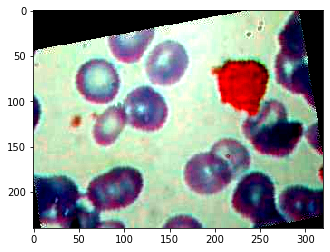

In [66]:
#used to preview images loaded in model
def imshow(img):
    #plt.imshow(img)
    npimg = img.numpy()[0]
    print(npimg.mean())
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
# get some random training images
dataiter = iter(train_loader)

images, labels = dataiter.next()
print(labels)
imshow(images)

In [67]:
mode_par_num = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of trained parameters in model: " + '{:,}'.format(mode_par_num).replace(',', ' '))

Liczba trenowanych parametrów w modelu: 257 981 444


In [68]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

In [71]:
from datetime import datetime
def save_model(test_acc):
    dic_out = {'model_params': model.state_dict(), 'optimizer_params': optimizer.state_dict()}
    df = pd.DataFrame.from_dict(dic_out)

    # datetime object containing current date and time
    now = datetime.now()
    print("now =", now)
    dt_string = now.strftime("%d_%m_%Y__%H_%M_%S")

    # save model dict on Google drive with time signature
    path = f'/content/drive/MyDrive/ML/CNN_BloodCell_{dt_string}_{test_acc}.csv'
    df.to_csv(path, index = False, header=True)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
start_time = time.time()
# Optional
wandb.watch(model, criterion, log="all", log_freq=400)
train_acc_best = 0
test_acc_best = 0
# Train Network
for epoch in range(num_epochs):
    print(f'epoch nr {epoch}')
    for data, targets in tqdm(train_loader):
        # Get data to device
        data = data.to(device=device)
        targets = targets.to(device=device)


        # setting parameteres gradients to None, takes less memory than setting to '0'
        for param in model.parameters():
            param.grad = None

        # forward and loss calculation
        scores=model(data)
        loss = criterion(scores, targets)
        # log loss to wandb
        wandb.log({"loss": loss})

        # backward
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
    # Calculate Accuracy and save model if test acc increased
    train_acc = check_accuracy(train_loader, model)*100
    test_acc = check_accuracy(test_loader, model)*100
    if test_acc > test_acc_best:
        save_model(test_acc)
        test_acc_best = test_acc
        train_acc_best = train_acc
        print(f'model saved: train_acc:{train_acc_best}, test_acc:{test_acc_best}')

    # log train_acc and test_acc to wandb
    wandb.log({"train_acc": train_acc})
    wandb.log({"test_acc": test_acc})
    print(f"Accuracy on training set: {train_acc:.2f}")    
    print(f"Accuracy on test set: {test_acc:.2f}")

    #print('cached CUDA memory: ',torch.cuda.memory_cached())
print("--- %s seconds ---" % (time.time() - start_time))
torch.cuda.empty_cache()
print(f"Highest accuracy on training set: {train_acc_best}")
print(f"Highest accuracy on test set: {test_acc_best}")

epoch nr 0


100%|██████████| 78/78 [00:06<00:00, 11.41it/s]


now = 2022-09-26 17:13:48.755133
model saved: train_acc:33.072208404541016, test_acc:31.845596313476562
Accuracy on training set: 33.07
Accuracy on test set: 31.85
epoch nr 1


100%|██████████| 78/78 [00:06<00:00, 11.17it/s]


now = 2022-09-26 17:16:02.778590
model saved: train_acc:48.679317474365234, test_acc:50.26136016845703
Accuracy on training set: 48.68
Accuracy on test set: 50.26
epoch nr 2


100%|██████████| 78/78 [00:08<00:00,  9.29it/s]


now = 2022-09-26 17:18:17.734009
model saved: train_acc:64.45716857910156, test_acc:69.64213562011719
Accuracy on training set: 64.46
Accuracy on test set: 69.64
epoch nr 3


100%|██████████| 78/78 [00:13<00:00,  5.97it/s]


now = 2022-09-26 17:20:30.840691
model saved: train_acc:79.59224700927734, test_acc:79.33252716064453
Accuracy on training set: 79.59
Accuracy on test set: 79.33
epoch nr 4


100%|██████████| 78/78 [00:07<00:00, 11.11it/s]


now = 2022-09-26 17:22:37.318486
model saved: train_acc:84.4531478881836, test_acc:79.6541976928711
Accuracy on training set: 84.45
Accuracy on test set: 79.65
epoch nr 5


100%|██████████| 78/78 [00:07<00:00, 11.14it/s]


now = 2022-09-26 17:24:52.419890
model saved: train_acc:88.08878326416016, test_acc:86.00724029541016
Accuracy on training set: 88.09
Accuracy on test set: 86.01
epoch nr 6


100%|██████████| 78/78 [00:07<00:00, 11.08it/s]


Accuracy on training set: 80.36
Accuracy on test set: 80.78
epoch nr 7


100%|██████████| 78/78 [00:13<00:00,  5.94it/s]


now = 2022-09-26 17:29:18.902513
model saved: train_acc:89.95681762695312, test_acc:87.4949722290039
Accuracy on training set: 89.96
Accuracy on test set: 87.49
epoch nr 8


100%|██████████| 78/78 [00:07<00:00, 11.09it/s]


Accuracy on training set: 87.50
Accuracy on test set: 78.33
epoch nr 9


100%|██████████| 78/78 [00:06<00:00, 11.22it/s]


Accuracy on training set: 86.30
Accuracy on test set: 81.14
epoch nr 10


100%|██████████| 78/78 [00:06<00:00, 11.18it/s]


Accuracy on training set: 83.98
Accuracy on test set: 80.34
epoch nr 11


100%|██████████| 78/78 [00:13<00:00,  5.95it/s]


Accuracy on training set: 92.86
Accuracy on test set: 85.77
epoch nr 12


100%|██████████| 78/78 [00:07<00:00, 11.02it/s]


Accuracy on training set: 94.78
Accuracy on test set: 84.52
epoch nr 13


100%|██████████| 78/78 [00:06<00:00, 11.33it/s]


Accuracy on training set: 59.48
Accuracy on test set: 60.64
epoch nr 14


100%|██████████| 78/78 [00:06<00:00, 11.23it/s]


Accuracy on training set: 94.73
Accuracy on test set: 85.73
epoch nr 15


100%|██████████| 78/78 [00:13<00:00,  5.96it/s]


Accuracy on training set: 95.28
Accuracy on test set: 86.57
epoch nr 16


100%|██████████| 78/78 [00:06<00:00, 11.21it/s]


Accuracy on training set: 92.15
Accuracy on test set: 87.37
epoch nr 17


100%|██████████| 78/78 [00:07<00:00, 11.11it/s]


Accuracy on training set: 94.25
Accuracy on test set: 85.97
epoch nr 18


100%|██████████| 78/78 [00:07<00:00, 11.09it/s]


Accuracy on training set: 95.85
Accuracy on test set: 86.81
epoch nr 19


100%|██████████| 78/78 [00:13<00:00,  5.95it/s]


Accuracy on training set: 97.66
Accuracy on test set: 83.88
epoch nr 20


100%|██████████| 78/78 [00:07<00:00, 11.00it/s]


Accuracy on training set: 97.43
Accuracy on test set: 86.13
epoch nr 21


100%|██████████| 78/78 [00:07<00:00, 11.12it/s]


Accuracy on training set: 93.51
Accuracy on test set: 81.87
epoch nr 22


100%|██████████| 78/78 [00:07<00:00, 10.92it/s]


Accuracy on training set: 97.49
Accuracy on test set: 85.32
epoch nr 23


100%|██████████| 78/78 [00:13<00:00,  5.89it/s]


Accuracy on training set: 97.36
Accuracy on test set: 86.25
epoch nr 24


100%|██████████| 78/78 [00:07<00:00, 10.92it/s]


Accuracy on training set: 97.56
Accuracy on test set: 85.81
epoch nr 25


100%|██████████| 78/78 [00:07<00:00, 11.09it/s]


Accuracy on training set: 99.00
Accuracy on test set: 86.81
epoch nr 26


100%|██████████| 78/78 [00:07<00:00, 11.01it/s]


Accuracy on training set: 98.53
Accuracy on test set: 85.81
epoch nr 27


100%|██████████| 78/78 [00:13<00:00,  5.90it/s]


Accuracy on training set: 99.26
Accuracy on test set: 86.97
epoch nr 28


100%|██████████| 78/78 [00:07<00:00, 10.84it/s]


Accuracy on training set: 98.28
Accuracy on test set: 84.56
epoch nr 29


100%|██████████| 78/78 [00:08<00:00,  8.67it/s]


Accuracy on training set: 97.69
Accuracy on test set: 86.65
epoch nr 30


100%|██████████| 78/78 [00:07<00:00, 11.05it/s]


Accuracy on training set: 98.63
Accuracy on test set: 84.48
epoch nr 31


100%|██████████| 78/78 [00:13<00:00,  5.83it/s]


Accuracy on training set: 98.99
Accuracy on test set: 87.17
epoch nr 32


100%|██████████| 78/78 [00:07<00:00, 10.94it/s]


Accuracy on training set: 99.51
Accuracy on test set: 87.05
epoch nr 33


100%|██████████| 78/78 [00:07<00:00, 11.14it/s]


Accuracy on training set: 98.52
Accuracy on test set: 87.29
epoch nr 34


100%|██████████| 78/78 [00:07<00:00, 11.06it/s]


Accuracy on training set: 99.45
Accuracy on test set: 86.37
epoch nr 35


100%|██████████| 78/78 [00:13<00:00,  5.89it/s]


Accuracy on training set: 99.51
Accuracy on test set: 87.09
epoch nr 36


100%|██████████| 78/78 [00:07<00:00, 11.00it/s]


Accuracy on training set: 97.34
Accuracy on test set: 86.29
epoch nr 37


100%|██████████| 78/78 [00:07<00:00, 11.11it/s]


Accuracy on training set: 98.46
Accuracy on test set: 86.77
epoch nr 38


 39%|███▉      | 123/312 [00:33<00:51,  3.66it/s]